# Travail préparatoire

In [231]:
def matrice1D(profil_init, S, x, t,cv, rho, k, xi, c, d):
    alpha = (cv * rho) / k
    
    #Profils initiaux
    N_x = len(x)
    dx = x[1] - x[0]
    
    dt = t[1]-t[0]

    #Init matrice A indep du temps
    A = np.zeros((N_x, N_x))
    A[np.arange(0, N_x), np.arange(0, N_x)] = -2
    A[np.arange(1, N_x), np.arange(0, N_x - 1)] = 1
    A[np.arange(0, N_x - 1), np.arange(1, N_x)] = 1
    
    A[0, [0, 1, 2]] = [2 * c[1] * dx - 3 * c[0], 4 * c[0], -c[0]]
    A[-1, [-3, -2, -1]] = [d[0], -4 * d[0], 2 * d[1] * dx + 3 * d[0]]
    
    #Init vecteur b indep du temps
    b = -S(x)/k * dx**2
    b[0] = -2 * c[2] * dx
    b[-1] = -2 * d[2] * dx
    
    #Init A et b dependant du temps
    M = np.identity(N_x)
    M[0, 0] = 0
    M[-1, -1] = 0
    
    temp = np.zeros((len(t),N_x))
    temp[0,:] = profil_init(x)
    
    b_prime = (M+dt/(alpha*dx**2)*A*(1-xi)) @ temp[0,:] - (dt / (alpha * dx**2)) * b
    A_prime = M - (dt / (alpha * dx**2)) * A*xi
    
    # Calcul de la solution pour chaque pas de temps
    for i in range(1,len(t)):
        temp[i,:] = np.linalg.solve(A_prime, b_prime)
        b_prime = M @ temp[i,:] - (dt / (alpha * dx**2)) * b 
    return temp

#  

## i) Obtention de $T^{max}_{eq}$

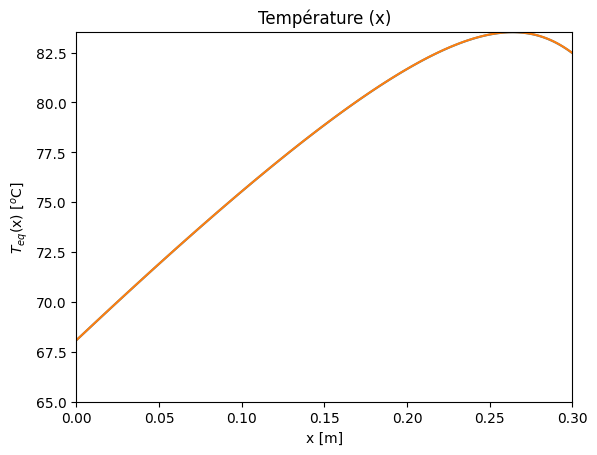

La température d'équilibre maximal est de 83.528 °C avec un incertitude absolue de 0.005 °C


In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt

# Équation différentielle: d^2 u/dx^2=g(x) sur x=(a,b)
# Conditions aux limites générales:
# x=a: c1*du/dx+c2*u+c3=0
# x=b: d1*du/dx+d2*u+d3=0

# Équation de transfert de chaleur d^2 T/dx^2=-S(x)/k sur x=(0,L)
# dans un mur d'isolation thermique
L=0.3; #[m] ; Épaisseur du mur

k=1;h=1;
# k=1;#[W/(m*K)]; La conductivité thermique de la brique
# h=1; #[W/(m^2*K)]; Coefficient de transfert thermique pour l'interface plane entre l'air et solide.

# Condition convective (de Robin) à x=0 (face externe du mur): -k*dT/dx=h(Ta-T)
Ta=-10; #[oC]
c1=-k; c2=h; c3=-h*Ta;
# Condition de Neumann à x=L (face interne du mur): dT/dx=0 - flux net de chaleur est 0
Ti = 20
d1=k; d2=h; d3=-h*Ti;

#(N+1) nœuds dans la maille
# Nmax=10000 pour 1G de mémoire

Nar1=np.array([100]); #dx=3mm

Nar=np.zeros(2*Nar1.size,dtype=Nar1.dtype);
Nar[np.arange(0,2*Nar1.size-1,2)]=Nar1.copy();
Nar[np.arange(0,2*Nar1.size-1,2)+1]=2*Nar1.copy();

ci=-1;
Err=np.zeros(Nar1.size,dtype=np.double);
tInv=np.zeros(Nar.size,dtype=np.double);
Tmax=np.zeros(Nar.size,dtype=np.double);

plt.figure(1)
for N in Nar:
    S=np.zeros(N+1,dtype=np.double);
    A=np.zeros((N+1,N+1),dtype=np.double);
    b=np.zeros(N+1,dtype=np.double);
    u=np.zeros(N+1,dtype=np.double);
    
    ci=ci+1;
    dx=L/N; #Pas de discrétisation
    x=np.linspace(0,L,N+1);
    
    # Sourse volumique de chaleur q[W/m^3] d'épaisseur dL
    # La source est intégrée dans la partie intérieure du mur
    dL=0.05; 
    q=2000; # W/m^3;
    S=q/(1+((x-L)/dL)**2)
    
    # matrice pleine
    A=np.diag(-2*np.ones(N+1),0)+np.diag(np.ones(N),-1)+np.diag(np.ones(N),1);
    
    A[0,0]=2*c2*dx-3*c1;A[0,1]=4*c1;A[0,2]=-c1;
    A[N,N]=3*d1+2*d2*dx;A[N,N-1]=-4*d1;A[N,N-2]=d1;
    b=-S/k*dx**2; b[0]=-2*c3*dx; b[N]=-2*d3*dx;
    
    tic=time.time_ns();
    u=np.linalg.solve(A, b); # Option préférée
    toc=time.time_ns();
    tInv[ci]=(toc-tic)/1e9; #temps en [s]   
    Tmax[ci]=u.max();
    plt.plot(x,u);
    T_eq_max = u.max();
    Err=np.abs(Tmax[np.arange(0,Tmax.size,2)]-Tmax[np.arange(1,Tmax.size,2)]);

erreur = Err[0]

plt.axis([x[0], x[-1], 65, Tmax.max()])
plt.title('Température (x)')
plt.xlabel('x [m]')    
plt.ylabel('$T_{eq}$(x) [$^o$C]')
plt.show()

print(f"La température d'équilibre maximal est de {T_eq_max:.3f} \u00B0C avec un incertitude absolue de {erreur:.3f} \u00B0C")


## ii) Application de la méthode en 1)

In [234]:
dL = 0.05
L = 0.3
q = 2000
Ta = -10
Ti = 20
h = 1
k = 1
Tw = ((Ti * k / L) + Ta * h) / ((k / L) + h)
dx = 0.003
cv = 1000
rho = 2000
x = np.arange(0, L + dx, dx)
t = np.arange(0, 1e6, dx ** 2 * (cv * rho / k))

input = {"profil_init": lambda x: Tw + (Ti - Tw) * x / L,
         "S": lambda x: q / (1 + ((x - L) / dL) ** 2),
         "x": x,
         "t": t,
         "cv": 1000,
         "rho": 2000,
         "k": 1,
         "xi": 1,
         "c": [-k, h, -h * Ta],
         "d": [0, 1, -Ti]}

temp = matrice1D(**input)   

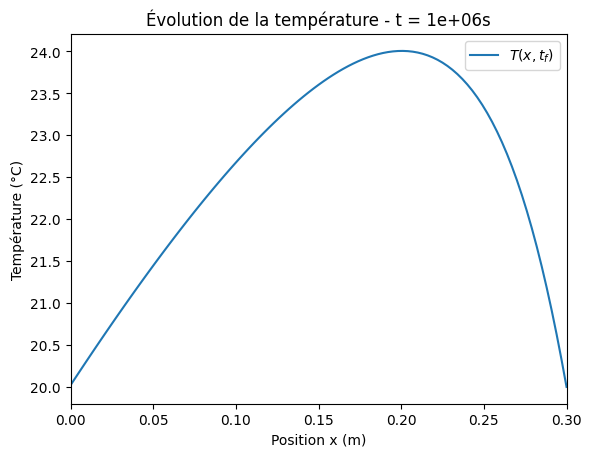

In [235]:
fig, ax = plt.subplots()
plt.plot(x,temp[-1,:], label = "$T(x,t_f)$")

ax.set_xlim(0, L)
ax.set_xlabel("Position x (m)")
ax.set_ylabel("Température (°C)")
ax.set_title(f"Évolution de la température - t = {t[-1]:.2g}s")
ax.legend()

plt.show()

Le temps d'équilibrage du système est 184464s


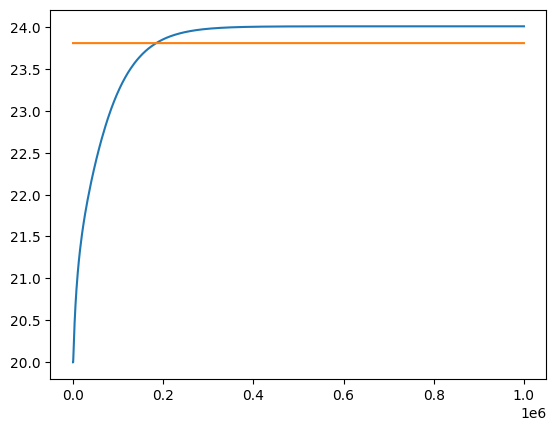

In [236]:
Tmax_array = np.array([np.max(temp[i,:]) for i in range(0,len(t))])
tho_eq = t[Tmax_array > np.max(temp[0])+0.95*(Tmax-np.max(temp[0]))][0]
plt.plot(t, Tmax_array)
plt.plot(t, (np.max(temp[0])+0.95*(Tmax-np.max(temp[0])))*np.ones_like(t))
print(f"Le temps d'équilibrage du système est {tho_eq:.0f}s")

# Tests

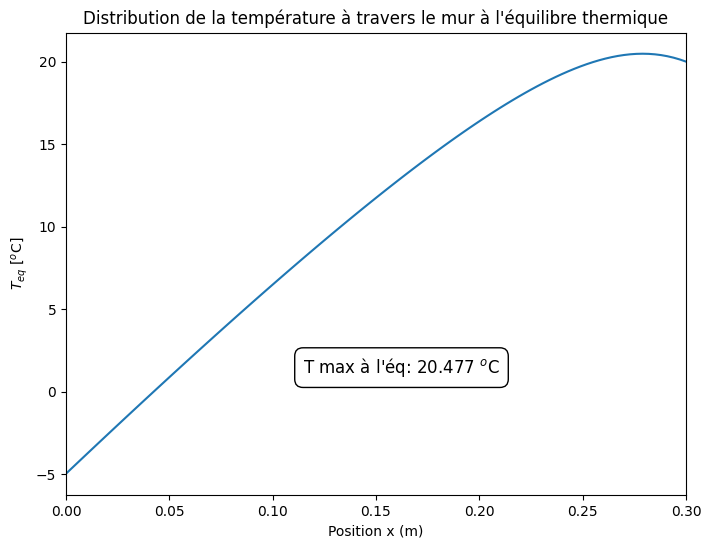

In [237]:
# Équation différentielle: d^2 u/dx^2=g(x) sur x=(a,b)
# Conditions aux limites générales:
# x=a: c1*du/dx+c2*u+c3=0
# x=b: d1*du/dx+d2*u+d3=0

# Équation de transfert de chaleur d^2 T/dx^2=-S(x)/k sur x=(0,L)
# dans un mur d'isolation thermique
L = 0.3; #[m] ; Épaisseur du mur

#k=0.85;h=20; #Valeurs pour vérifier
k=0.85; h=20
# k=1;#[W/(m*K)]; La conductivité thermique de la brique
# h=1; #[W/(m^2*K)]; Coefficient de transfert thermique pour l'interface plane entre l'air et solide.

# Condition convective (de Robin) à x=0 (face externe du mur): -k*dT/dx=h(Ta-T)
#Température extérieure
Ta=-10; #[oC]
Ta = Ta + 273 #K
#Température intérieure
Ti = 20
Ti = Ti + 273 #K
c1=-k; c2=h; c3=-h*Ta;
# Condition de Dirichler à x=L (face interne du mur): T(L) = Ti, température maintenue constante
d1=0; d2=1; d3=-Ti;

#(N+1) nœuds dans la maille
# Nmax=10000 pour 1G de mémoire


dx = 3/1000 # 3 mm
N = int(L/dx) #Pas de discrétisation
x=np.linspace(0,L,N+1);

S=np.zeros(N+1,dtype=np.double);
A=np.zeros((N+1,N+1),dtype=np.double);
b=np.zeros(N+1,dtype=np.double);
u=np.zeros(N+1,dtype=np.double);

# Sourse volumique de chaleur q[W/m^3] d'épaisseur dL
# La source est intégrée dans la partie intérieure du mur
dL=0.05; 
q=2000; # W/m^3;
#S=q*np.exp(-((x-L)/dL)**2)
S = q/(1 + ((x-L)/dL)**2) 


# matrice pleine
A=np.diag(-2*np.ones(N+1),0)+np.diag(np.ones(N),-1)+np.diag(np.ones(N),1);

#Ajouts des CF dans A
A[0,0]=2*c2*dx-3*c1;
A[0,1]=4*c1;
A[0,2]=-c1;
A[N,N]=3*d1+2*d2*dx;
A[N,N-1]=-4*d1;
A[N,N-2]=d1;

#Construction de b en incluant les CF
b=-S/k*dx**2; 
b[0]=-2*c3*dx; 
b[N]=-2*d3*dx;

#Résolution du système
u=np.linalg.solve(A, b) - 273; # -273 pour reconvertir en oC

Tmax = np.max(u)

plt.figure(figsize=(8,6))
plt.plot(x, u)
# Add a text box in the upper right corner
plt.text(0.7, 0.30, f"T max à l'éq: {Tmax:.3f} $^o$C", 
         fontsize=12, ha="right", va="top", transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
plt.title("Distribution de la température à travers le mur à l'équilibre thermique")
plt.xlabel("Position x (m)")
plt.ylabel("$T_{eq}$ [$^o$C]")
plt.xlim((0,0.3))
plt.show()

In [238]:
dL = 0.05
L = 0.3
q = 2000
Ta = -10
Ti = 20
h = 20
k = 0.85
Tw = ((Ti * k / L) + Ta * h) / ((k / L) + h)
dx = 0.003
cv = 1000
rho = 2000
x = np.arange(0, L + dx, dx)
t = np.arange(0, 1e6, dx ** 2 * (cv * rho / k))

input = {"profil_init": lambda x: Tw + (Ti - Tw) * x / L,
         "S": lambda x: q / (1 + ((x - L) / dL) ** 2),
         "x": x,
         "t": t,
         "cv": 1000,
         "rho": 2000,
         "k": .85,
         "xi":1,
         "c": [-k, h, -h * Ta],
         "d": [0, 1, -Ti]}

temp = matrice1D(**input)
temp

array([[-6.27737226, -6.01459854, -5.75182482, ..., 19.47445255,
        19.73722628, 20.        ],
       [-6.27683289, -6.01402728, -5.75123405, ..., 19.49212558,
        19.75015079, 20.        ],
       [-6.27630366, -6.01346537, -5.75064881, ..., 19.50694468,
        19.75939866, 20.        ],
       ...,
       [-4.95967355, -4.60417762, -4.24926533, ..., 20.23837884,
        20.12973967, 20.        ],
       [-4.95967355, -4.60417762, -4.24926533, ..., 20.23837884,
        20.12973967, 20.        ],
       [-4.95967355, -4.60417762, -4.24926533, ..., 20.23837884,
        20.12973967, 20.        ]], shape=(47223, 101))

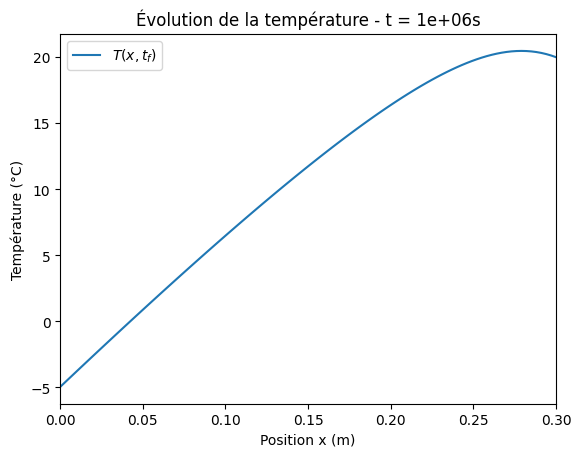

In [239]:
fig, ax = plt.subplots()
plt.plot(x, temp[-1, :], label="$T(x,t_f)$")

ax.set_xlim(0, L)
ax.set_xlabel("Position x (m)")
ax.set_ylabel("Température (°C)")
ax.set_title(f"Évolution de la température - t = {t[-1]:.2g}s")
ax.legend()

plt.show()

Le temps d'équilibrage du système est 102515s


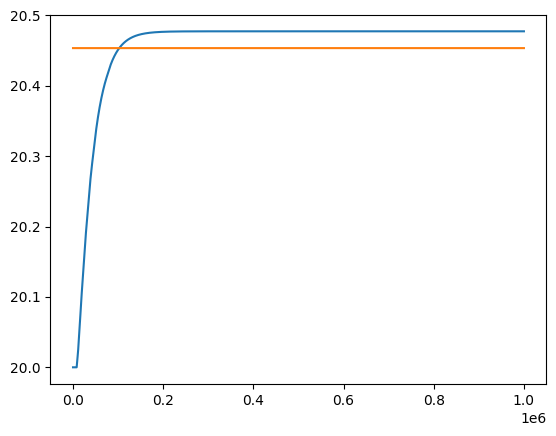

In [240]:
Tmax_array = np.array([np.max(temp[i,:]) for i in range(0,len(t))])
tho_eq = t[Tmax_array > np.max(temp[0])+0.95*(Tmax-np.max(temp[0]))][0]
plt.plot(t, Tmax_array)
plt.plot(t, (np.max(temp[0])+0.95*(Tmax-np.max(temp[0])))*np.ones_like(t))
print(f"Le temps d'équilibrage du système est {tho_eq:.0f}s")